<a href="https://colab.research.google.com/github/prakharxagrawal/Google-Collab-Notebooks/blob/main/cv_assignment_switchon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python Script to generate more data

In [ ]:
import os
import cv2
import random
import numpy as np
from skimage import io, img_as_ubyte
from skimage.util import random_noise
from skimage.transform import rotate, AffineTransform, warp

def anticlockwise_rotation(image):
    angle = random.randint(0, 180)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle = random.randint(0, 180)
    return rotate(image, -angle)

def h_flip(image):
    return np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(image, (9,9), 0)

def warp_shift(image):
    transform = AffineTransform(translation=(0, 40))
    warp_image = warp(image, transform, mode="wrap")
    return warp_image

def contrast_image(image):
    contrast = 50
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image[:,:,2] = [[max(pixel - contrast, 0) if pixel < 190 else min(pixel + contrast, 255) for pixel in row] for row in image[:,:,2]]
    image= cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    return image

def shifting_up(image):
    WIDTH, HEIGHT, CHANNEL = image.shape
    for j in range(WIDTH):
        for i in range(HEIGHT):
            if (j < WIDTH - 20 and j > 20):
                image[j][i] = image[j + 20][i]
            else:
                image[j][i] = 0
    return image


#saturation
def saturation(image):
    bad_hsv=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    bad_hsv[...,1]=bad_hsv[...,1]*7
    image=cv2.cvtColor(bad_hsv,cv2.COLOR_HSV2BGR)
    return image



transformation = {'rotate anticlockwise' : anticlockwise_rotation,
                  'rotate clockwise' : clockwise_rotation,
                  'horizontal flip' : h_flip,
                  'vertical_flip' : v_flip,
                  'warp shift' : warp_shift,
                  'adding noise' : add_noise,
                  'blurring image' : blur_image,
                  'contrast image' : contrast_image,
                  'shifting up' : shifting_up,
                  'saturation' : saturation
                  }

#image_path= r'C:\\Users\\ASUS\\Desktop\\bad_image'
image_path = r"C:\Users\agrpr\Desktop\good_image"
images = []

#augmented_path = r'C:\\Users\\ASUS\\Desktop\\SwitchOn\\aug_bad_image'
augmented_path = r'C:\Users\agrpr\Desktop\aug_good_image'

for im in os.listdir(image_path):  # read image name from folder and append its path into "images" array
    images.append(os.path.join(image_path,im))


image_to_gen = 100
i = 1

while i <= image_to_gen:
    image = images[0]
    original_image = io.imread(image)
    transformed_image = None
    n = 0
    transformation_count = random.randint(1, len(transformation))

    while n <= transformation_count:
        key = random.choice(list(transformation))
        transformed_image = transformation[key](original_image)
        n = n + 1
    new_image_path = "%s/augmented_image_%s.jpg" %(augmented_path, i)
    transformed_image = img_as_ubyte(transformed_image)
    transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(new_image_path, transformed_image)
    print("Writing {}.jpg".format(i))
    i += 1


#*Mounting the Drive to the Colab.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive')

In [ ]:
!ls

 best_model.h5	    darknet				 SwitchOn       yolov3
'Colab Notebooks'  'Getting started.pdf'		 SwitchOn_out
 Computer-Vision   "Piyush Kumar Sahoo's Resume-1.pdf"	 vgg16_1.h5


# Splitting the data into 3 different types in ratio(80, 10, 10)
       

#1.   Training Data
#2.   Validation Data
#3.   Test Data



In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("SwitchOn", output='SwitchOn_out', seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 200 files [02:27,  1.36 files/s]


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=40,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True)

In [ ]:
train_datagen = image_datagen.flow_from_directory('SwitchOn_out/train/', target_size=(256,256),batch_size=8,class_mode='categorical')
val_datagen = image_datagen.flow_from_directory('SwitchOn_out/test/',target_size=(256,256),batch_size=8,class_mode='categorical')

Found 160 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


#Importing all the Necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Dense, Flatten


# Used VGG16 Pretrained model and removed the top layer.

In [ ]:
import keras
from keras.applications import vgg16
from keras.models import Model
vgg = vgg16.VGG16(include_top=False, weights='imagenet',
                                     input_shape=(256,256,3))
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False


58892288/58889256 [==============================] - 2s 0us/step


## Summary of the model

In [ ]:
vgg_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

## Added necessary last layer.

In [ ]:
model = Sequential()
model.add(vgg_model)
model.add(Dense(256, activation='relu', input_shape=(256, 256, 3)))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer = SGD(lr=0.0001, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 32768)             14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 23,104,066
Trainable params: 8,389,378
Non-trainable params: 14,714,688
_________________________________________________________________


#Step 7- And the last Step of modeling, fitting the data in our model.

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


results = model.fit(train_datagen, steps_per_epoch=18, epochs=50, validation_data= val_datagen, validation_steps=10 , callbacks=[checkpoint])
model.save_weights("vgg16_1.h5")


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.7547 - accuracy: 0.4097WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 10 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_accuracy improved from -inf to 0.55000, saving model to best_model.h5
18/18 [==============================] - 143s 8s/step - loss: 0.7547 - accuracy: 0.4097 - val_loss: 0.7244 - val_accuracy: 0.5500
Epoch 2/50
18/18 [==============================] - 9s 504ms/step - loss: 0.6987 - accuracy: 0.5347
Epoch 3/50
18/18 [==============================] - 4s 200ms/step - loss: 0.6900 - accuracy: 0.5208
Epoch 4/50
18/18 [==============================] - 3s 167ms/step - loss: 0.6727 - accuracy: 0.5625
Epoch 5/50
18/18 [==============================] - 3s 170ms/step - loss: 0.6858 - accuracy: 0.6458
Epoch 6/50
18/18 [=====

In [ ]:
test_datagen = image_datagen.flow_from_directory('SwitchOn_out/test/',target_size=(256,256),batch_size=1, shuffle = False, class_mode='categorical',
    subset=None)

Found 20 images belonging to 2 classes.


## Evaluate performance on train & test datasets

In [ ]:

loss, acc = model.evaluate_generator(train_datagen, steps=len(train_datagen)//8, verbose=1, workers=3)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))

loss, acc = model.evaluate_generator(test_datagen, steps=len(test_datagen), verbose=1, workers=3)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

Instructions for updating:
Please use Model.evaluate, which supports generators.
2/2 [==============================] - 0s 20ms/step - loss: 0.2541 - accuracy: 1.0000
Training data  -> loss: 0.254, acc: 1.000
20/20 [==============================] - 0s 14ms/step - loss: 0.3066 - accuracy: 0.9000
Testing data   -> loss: 0.307, acc: 0.900


# The Classification Report, that tells everything related to evaluation starting from Precision, Recall F1-Score etc.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
# batch_size = 1
# num_of_test_samples = 2069
predictions = model.predict_generator(test_datagen,  len(test_datagen))

y_pred = np.argmax(predictions, axis=1)

true_classes = test_datagen.classes

class_labels = list(test_datagen.class_indices.keys())

print(class_labels)

print(confusion_matrix(test_datagen.classes, y_pred))

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

Instructions for updating:
Please use Model.predict, which supports generators.
['bad_image', 'good_image']
[[ 9  1]
 [ 0 10]]
              precision    recall  f1-score   support

   bad_image       1.00      0.90      0.95        10
  good_image       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



#Defining function for confusion matrix plot

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Visualizing
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

#Plotting normalized confusion matrix

Normalized confusion matrix


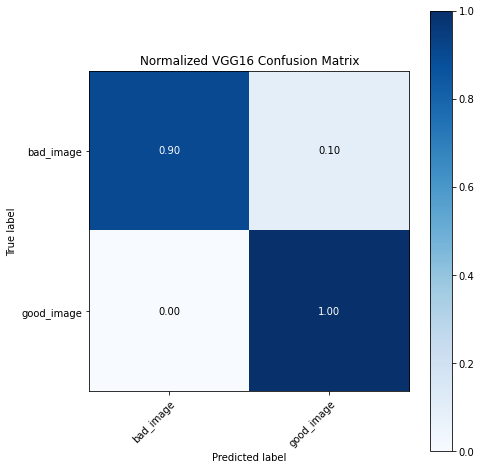

In [ ]:
plot_confusion_matrix(true_classes, y_pred, classes = class_labels, normalize=True,  title = 'Normalized VGG16 Confusion Matrix')

In [ ]:
import os
os.chdir('/content/drive/My Drive')

In [ ]:
test_datagen = image_datagen.flow_from_directory('SwitchOn_out/test/',target_size=(256,256),batch_size=1, shuffle = False, class_mode='categorical',
    subset=None)

Found 20 images belonging to 2 classes.


In [ ]:
test_datagen.filenames

['bad_image/augmented_image_28.jpg',
 'bad_image/augmented_image_47.jpg',
 'bad_image/augmented_image_50.jpg',
 'bad_image/augmented_image_53.jpg',
 'bad_image/augmented_image_70.jpg',
 'bad_image/augmented_image_75.jpg',
 'bad_image/augmented_image_76.jpg',
 'bad_image/augmented_image_80.jpg',
 'bad_image/augmented_image_90.jpg',
 'bad_image/augmented_image_93.jpg',
 'good_image/augmented_image_28.jpg',
 'good_image/augmented_image_47.jpg',
 'good_image/augmented_image_50.jpg',
 'good_image/augmented_image_53.jpg',
 'good_image/augmented_image_70.jpg',
 'good_image/augmented_image_75.jpg',
 'good_image/augmented_image_76.jpg',
 'good_image/augmented_image_80.jpg',
 'good_image/augmented_image_90.jpg',
 'good_image/augmented_image_93.jpg']

In [ ]:
#Taking the the image-> 'bad_image/augmented_image_28.jpg'
test_datagen[0] #Bad_image.

(array([[[[0.28906307, 0.28906307, 0.28261414],
          [0.32138613, 0.3257751 , 0.3157375 ],
          [0.35600668, 0.36617887, 0.3567432 ],
          ...,
          [0.25546294, 0.21624726, 0.23996018],
          [0.26831767, 0.23157877, 0.25985548],
          [0.2683269 , 0.23808503, 0.26527122]],
 
         [[0.30064413, 0.30064413, 0.29998574],
          [0.2890777 , 0.2890777 , 0.28263614],
          [0.32132757, 0.3257092 , 0.31567523],
          ...,
          [0.2552107 , 0.21659936, 0.25611064],
          [0.2758166 , 0.24182987, 0.26339883],
          [0.25993285, 0.23177882, 0.26526058]],
 
         [[0.29682863, 0.29426253, 0.307093  ],
          [0.30065876, 0.30065876, 0.30000773],
          [0.2890923 , 0.2890923 , 0.2826581 ],
          ...,
          [0.2699003 , 0.23338744, 0.26030767],
          [0.26742256, 0.23763286, 0.26549733],
          [0.2515388 , 0.22128628, 0.26106355]],
 
         ...,
 
         [[0.4077275 , 0.41987503, 0.4202578 ],
          [0.38236

In [ ]:
model = load_model('best_model.h5')
predictions = model.predict_generator(test_datagen[0],  1)

y_pred = np.argmax(predictions, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
##Reference point
##[0]->Bad Image,[1]->Good Image
print(y_pred)

[0]


1.   Both the images were read
2.   Both the images were converted to greyscale images
3.   compare_ssim from skimages were imported
4.   This function gives 2 results score and and difference in the images.
5.   Contours were found in the images.
6.   Area of each of the contours were calculated to filter out the remaning unecessary contours.
7.   Based on trial and error method an area of more than 5000 was appropriate for our scencario,hence any countour of area lesser than 5000 was filtered and a bouding box was drawn around the defect to exactly pin-point the defect.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.


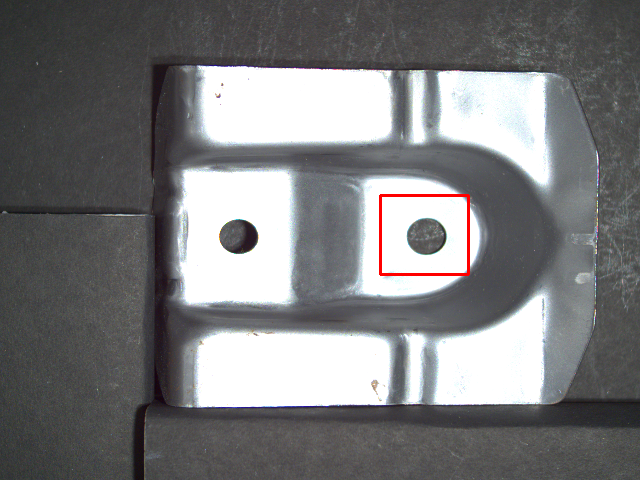

In [ ]:
import cv2
import numpy as np
import imutils
from google.colab.patches import cv2_imshow
from skimage.measure import compare_ssim
bad=cv2.imread('/content/drive/My Drive/augmented_image_1.png')
good=cv2.imread('/content/drive/My Drive/augmented_image_28.png')
bad_grey=cv2.cvtColor(bad,cv2.COLOR_BGR2GRAY)
good_grey=cv2.cvtColor(good,cv2.COLOR_BGR2GRAY)
(score,diff)=compare_ssim(bad_grey,good_grey,full=True)
diff=(diff*255).astype(np.uint8)
thresh=cv2.threshold(diff, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
count=0
for c in cnts:
    area = cv2.contourArea(c)
    count+=1
    if area>5000:
        (x,y,w,h)=cv2.boundingRect(c)
        cv2.rectangle(bad, (x, y), (x + w, y + h), (0, 0, 255), 2)
cv2_imshow(bad)